In [5]:
from google.colab import files

# upload multiple files
uploads = files.upload()

Saving categories.csv to categories.csv
Saving cities.csv to cities.csv
Saving countries.csv to countries.csv
Saving customers.csv to customers.csv
Saving employees.csv to employees.csv
Saving products.csv to products.csv


In [6]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import io
import re # regex module

In [7]:
# imported large Sales Dataset separately
sales_df = pd.read_csv('/content/sales.csv')


In [8]:
# Remove numbers in parentheses and extension
dataframes = {
    re.sub(r"\(\d+\)", "", filename).rsplit(".", 1)[0].strip(): pd.read_csv(io.BytesIO(file))
    for filename, file in uploads.items()
}

# Load the large dataset separately
dataframes["sales"] = sales_df

# Verify loaded DataFrames
print("Loaded DataFrames:", list(dataframes.keys()))


Loaded DataFrames: ['categories', 'cities', 'countries', 'customers', 'employees', 'products', 'sales']


In [9]:
# Top 5 rows for each df
for name, df in dataframes.items():
    print(f"DataFrame: {name}")
    print(df.head())


DataFrame: categories
   CategoryID CategoryName
0           1  Confections
1           2   Shell fish
2           3      Cereals
3           4        Dairy
4           5    Beverages
DataFrame: cities
   CityID        CityName  Zipcode  CountryID
0       1          Dayton    80563         32
1       2         Buffalo    17420         32
2       3         Chicago    44751         32
3       4         Fremont    20641         32
4       5  Virginia Beach    62389         32
DataFrame: countries
   CountryID CountryName CountryCode
0          1     Armenia          AN
1          2      Canada          FO
2          3      Belize          MK
3          4      Uganda          LV
4          5    Thailand          VI
DataFrame: customers
   CustomerID FirstName MiddleInitial LastName  CityID  \
0           1  Stefanie             Y     Frye      79   
1           2     Sandy             T    Kirby      96   
2           3       Lee             T    Zhang      55   
3           4    Regina   

In [10]:
# duplicate values
for name, df in dataframes.items():
    duplicates = df.duplicated().sum()
    print(f"DataFrame: {name} - Duplicates: {duplicates}")


DataFrame: categories - Duplicates: 0
DataFrame: cities - Duplicates: 0
DataFrame: countries - Duplicates: 0
DataFrame: customers - Duplicates: 0
DataFrame: employees - Duplicates: 0
DataFrame: products - Duplicates: 0
DataFrame: sales - Duplicates: 0


In [11]:
# structure and data types
for name, df in dataframes.items():
    print(f"DataFrame: {name}")
    print(df.info(), "\n")


DataFrame: categories
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CategoryID    11 non-null     int64 
 1   CategoryName  11 non-null     object
dtypes: int64(1), object(1)
memory usage: 308.0+ bytes
None 

DataFrame: cities
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   CityID     96 non-null     int64 
 1   CityName   96 non-null     object
 2   Zipcode    96 non-null     int64 
 3   CountryID  96 non-null     int64 
dtypes: int64(3), object(1)
memory usage: 3.1+ KB
None 

DataFrame: countries
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   CountryID    206 non-nu

In [12]:
# missing values
for name, df in dataframes.items():
    missing_values = df.isnull().sum().sum()
    print(f"DataFrame: {name} - Missing Values: {missing_values}")

DataFrame: categories - Missing Values: 0
DataFrame: cities - Missing Values: 0
DataFrame: countries - Missing Values: 1
DataFrame: customers - Missing Values: 977
DataFrame: employees - Missing Values: 0
DataFrame: products - Missing Values: 0
DataFrame: sales - Missing Values: 1818


In [33]:
# Fill missing values

# Fill missing CountryCode in 'countries' dataframe
dataframes['countries']['CountryCode'] = dataframes['countries']['CountryCode'].fillna('AU')

# Fill missing MiddleInitial in 'customers' dataframe
dataframes['customers']['MiddleInitial'] = dataframes['customers']['MiddleInitial'].fillna('J')

# Convert 'SalesDate' to datetime before filling missing values
dataframes['sales']['SalesDate'] = pd.to_datetime(dataframes['sales']['SalesDate'])

# Fill missing dates with latest date
latest_date = dataframes['sales']['SalesDate'].max()
dataframes['sales']['SalesDate'] = dataframes['sales']['SalesDate'].fillna(latest_date)

# Merge Price from products into sales
merged_sales = dataframes['sales'].merge(
    dataframes['products'][['ProductID', 'Price']].rename(columns={'Price': 'ProductPrice'}),
    on='ProductID',
    how='left'
)

# Fill missing ProductPrice
merged_sales['ProductPrice'] = merged_sales['ProductPrice'].fillna(0)

# Fill TotalPrice column with Final sale price after discounts
merged_sales['TotalPrice'] = merged_sales['Quantity'] * merged_sales['ProductPrice'] * (1 - merged_sales['Discount'])

# original price before discount
merged_sales['before_d_Price'] = merged_sales['Quantity'] * merged_sales['ProductPrice']

print(merged_sales[['TotalPrice', 'before_d_Price']].head())

# Final check for missing values
for name, df in dataframes.items():
    missing_values = df.isnull().sum().sum()
    print(f"DataFrame: {name} - Missing Values: {missing_values:,}")


   TotalPrice  before_d_Price
0   309.63590        309.6359
1   437.82200        437.8220
2  1896.44160       1896.4416
3  1236.01384       1545.0173
4   719.80200        719.8020
DataFrame: categories - Missing Values: 0
DataFrame: cities - Missing Values: 0
DataFrame: countries - Missing Values: 0
DataFrame: customers - Missing Values: 0
DataFrame: employees - Missing Values: 0
DataFrame: products - Missing Values: 0
DataFrame: sales - Missing Values: 0


In [15]:
# top-performing products by total revenue and quantity sold

top_products_revenue = merged_sales.groupby('ProductID')['TotalPrice'].sum().sort_values(ascending=False).head(10)
top_products_quantity = merged_sales.groupby('ProductID')['Quantity'].sum().sort_values(ascending=False).head(10)

print("Top Products by Revenue:")
print(top_products_revenue)

print("\nTop Products by Quantity Sold:")
print(top_products_quantity)


Top Products by Revenue:
ProductID
80     533346.85008
98     527232.77695
248    524296.65277
199    518574.26060
268    513922.98375
298    505462.04052
217    502444.51200
371    498764.03616
201    495227.28109
392    494299.50471
Name: TotalPrice, dtype: float64

Top Products by Quantity Sold:
ProductID
361    6302
258    6239
371    6238
430    6168
330    6093
240    5959
47     5952
44     5944
93     5932
218    5859
Name: Quantity, dtype: int64


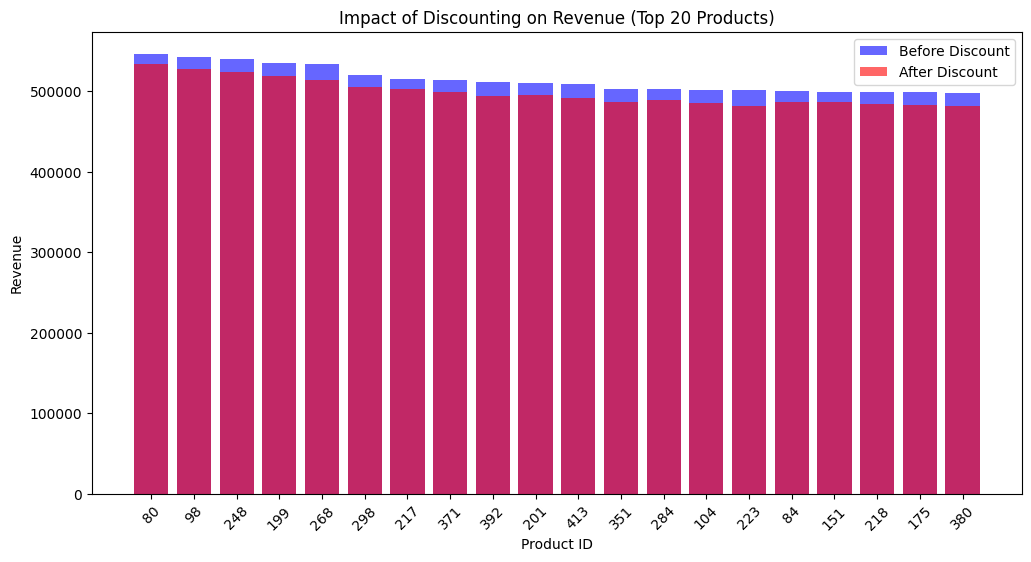

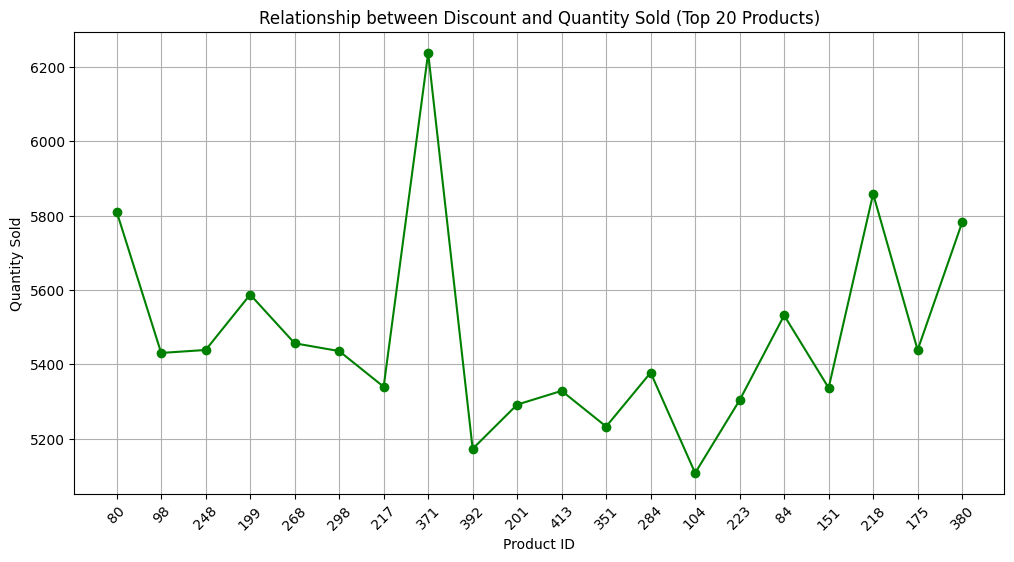

In [31]:
# How discounting affect total sales and revenue.

# Aggregated revenue and quantity before and after discount
discount_impact = merged_sales.groupby("ProductID").agg({
    "before_d_Price": "sum",
    "TotalPrice": "sum",
    "Quantity": "sum"
}).reset_index()

# Calculated revenue change due to discount
discount_impact["Revenue_Loss (%)"] = ((discount_impact["before_d_Price"] - discount_impact["TotalPrice"]) / discount_impact["before_d_Price"]) * 100

# Sorted by revenue before discounting
top_products = discount_impact.sort_values(by="before_d_Price", ascending=False).head(20)

# Ploted revenue before and after discount
plt.figure(figsize=(12, 6))
plt.bar(top_products["ProductID"].astype(str), top_products["before_d_Price"], label="Before Discount", color="blue", alpha=0.6)
plt.bar(top_products["ProductID"].astype(str), top_products["TotalPrice"], label="After Discount", color="red", alpha=0.6)
plt.xlabel("Product ID")
plt.ylabel("Revenue")
plt.title("Impact of Discounting on Revenue (Top 20 Products)")
plt.xticks(rotation=45)
plt.legend()
plt.show()

# relationship between discount and quantity sold
plt.figure(figsize=(12, 6))
plt.plot(top_products["ProductID"].astype(str), top_products["Quantity"], marker="o", linestyle="-", color="green")
plt.xlabel("Product ID")
plt.ylabel("Quantity Sold")
plt.title("Relationship between Discount and Quantity Sold (Top 20 Products)")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()





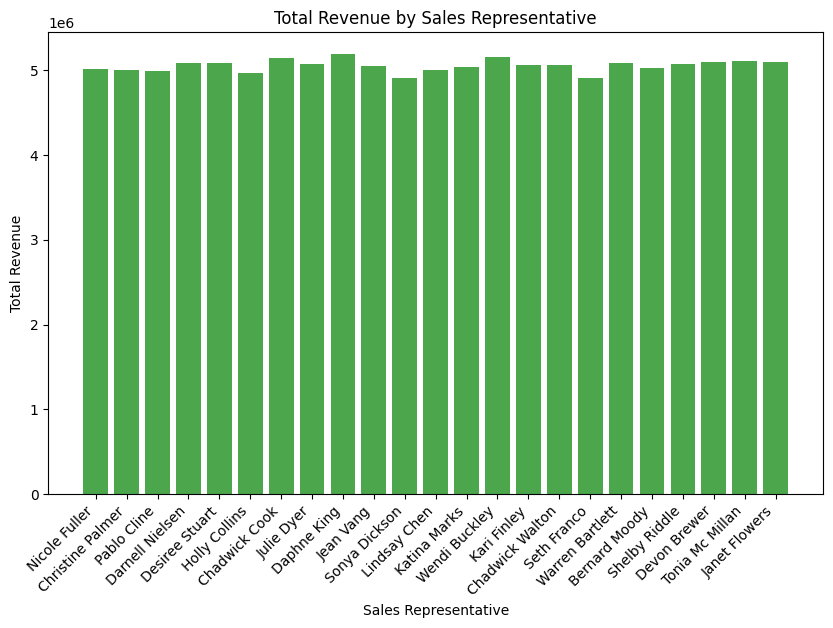

In [17]:
# sales representatives generating highest revenue.

sales_by_rep = merged_sales.groupby("SalesPersonID")["TotalPrice"].sum().reset_index()
sales_by_rep

# Merge with employees to get salesperson names
sales_by_rep = sales_by_rep.merge(dataframes['employees'], left_on="SalesPersonID", right_on="EmployeeID", how="left")

# Plot total revenue per salesperson
plt.figure(figsize=(10, 6))
plt.bar(sales_by_rep["FirstName"] + " " + sales_by_rep["LastName"], sales_by_rep["TotalPrice"], color="green", alpha=0.7)
plt.xlabel("Sales Representative")
plt.ylabel("Total Revenue")
plt.title("Total Revenue by Sales Representative")
plt.xticks(rotation=45, ha='right')
plt.show()

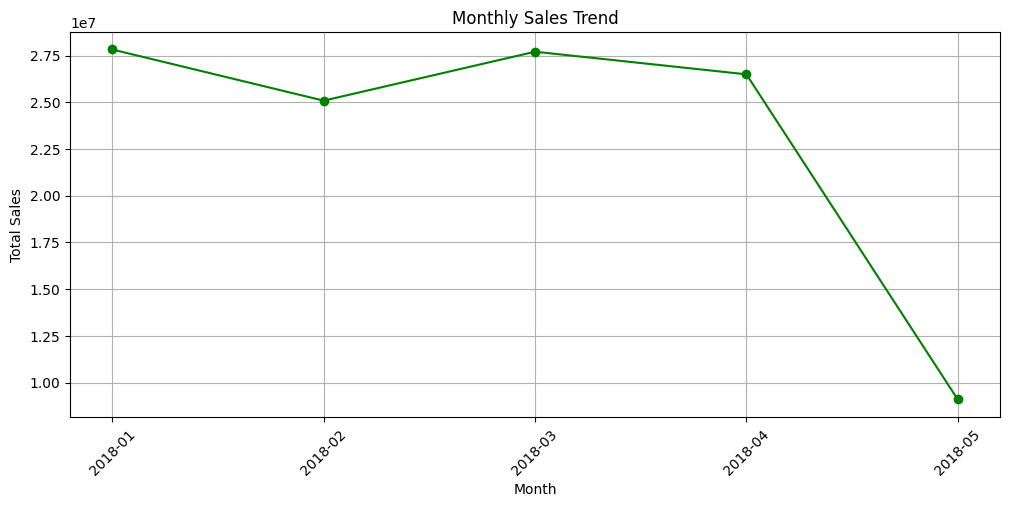

In [18]:
# Trend of sales over time(monthly)

# Sales Date to DateTime Format
merged_sales["SalesDate"] = pd.to_datetime(merged_sales["SalesDate"])

# Extract Month for Aggregation
merged_sales["Month"] = merged_sales["SalesDate"].dt.to_period("M")

# monthly trends
monthly_sales = merged_sales.groupby("Month")["TotalPrice"].sum().reset_index()
monthly_sales["Month"] = monthly_sales["Month"].astype(str)  # Convert period to string

# trends visual
# Monthly Sales Trend
plt.figure(figsize=(12, 5))
plt.plot(monthly_sales["Month"], monthly_sales["TotalPrice"], marker="o", linestyle="-", color="green")
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.title("Monthly Sales Trend")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


2. Customer Insights



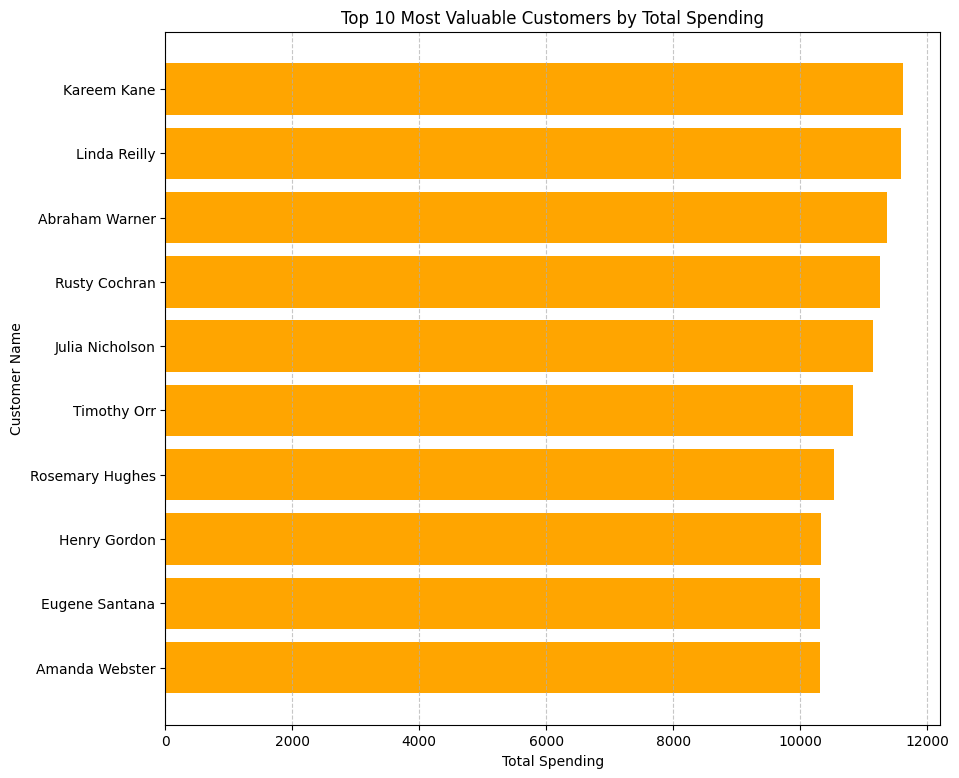

In [20]:
# Customer Insights

# The most valuable customers based on total spending.

# agg
customer_spending = merged_sales.groupby("CustomerID")["TotalPrice"].sum().reset_index()

customer_spending = customer_spending.merge(
    dataframes["customers"][["CustomerID", "FirstName", "LastName"]],
    on="CustomerID",
    how="left"
)

# sort
customer_spending = customer_spending.sort_values(by="TotalPrice", ascending=False)

top_customers = customer_spending.head(10)

# Plot
plt.figure(figsize=(10, 9))
plt.barh(top_customers["FirstName"] + " " + top_customers["LastName"], top_customers["TotalPrice"], color="orange")
plt.xlabel("Total Spending")
plt.ylabel("Customer Name")
plt.title("Top 10 Most Valuable Customers by Total Spending")
plt.gca().invert_yaxis()
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()



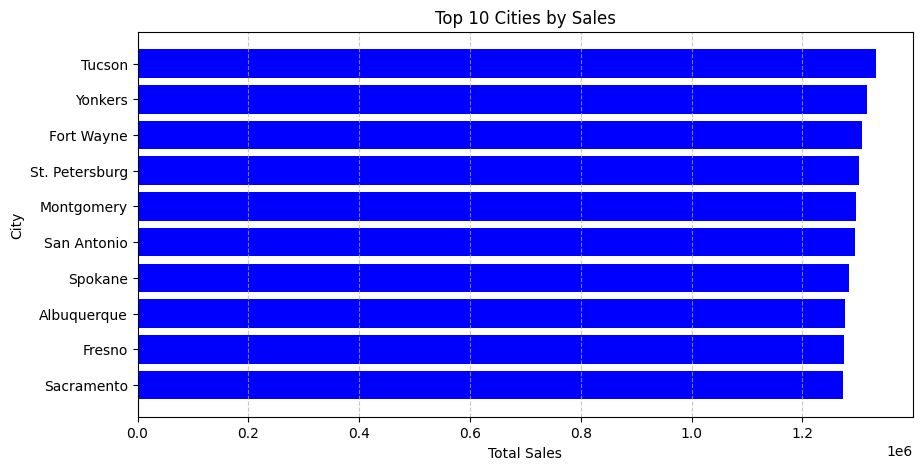

In [21]:
# How sales vary across different customer locations

# Grouped by CustomerID to get total sales per customer
sales_by_customer = merged_sales.groupby("CustomerID")["TotalPrice"].sum().reset_index()

# Merged with customer details to get CityID
sales_by_customer = sales_by_customer.merge(
    dataframes["customers"][["CustomerID", "CityID"]],
    on="CustomerID",
    how="left"
)

# Merged with cities to get CityName
sales_by_customer = sales_by_customer.merge(
    dataframes["cities"][["CityID", "CityName"]],
    on="CityID",
    how="left"
)

# Sum total sales by City
sales_by_city = sales_by_customer.groupby("CityName")["TotalPrice"].sum().reset_index()

# top 10 cities by sales
sales_by_city = sales_by_city.sort_values(by="TotalPrice", ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 5))
plt.barh(sales_by_city["CityName"], sales_by_city["TotalPrice"], color="blue")
plt.xlabel("Total Sales")
plt.ylabel("City")
plt.title("Top 10 Cities by Sales")
plt.gca().invert_yaxis()
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()


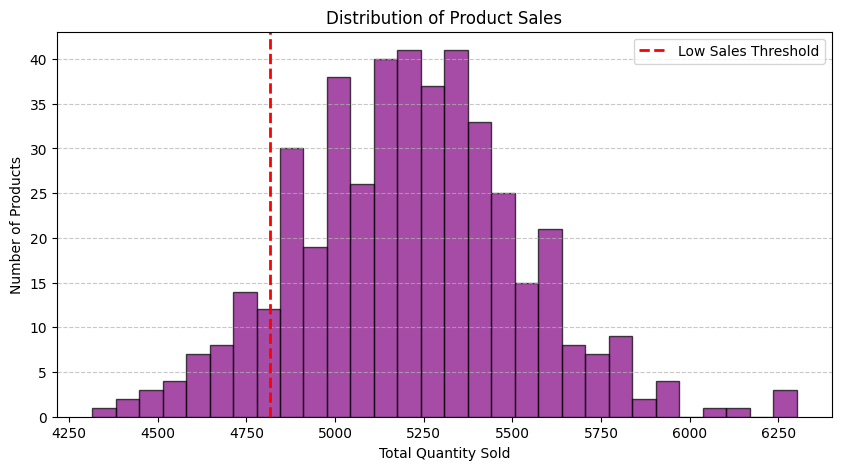

In [22]:
# Product Performance

# products with consistently low sales. Should they be discontinued?

product_sales = merged_sales.groupby("ProductID")["Quantity"].sum().reset_index()

product_sales = product_sales.merge(
    dataframes["products"][["ProductID", "ProductName"]],
    on="ProductID",
    how="left"
)

# 10th percentile threshold
low_sales_threshold = np.percentile(product_sales["Quantity"], 10)

# Filter products below the threshold
low_selling_products = product_sales[product_sales["Quantity"] <= low_sales_threshold]

# low-selling products
low_selling_products.sort_values(by="Quantity", ascending=True)

# plot
plt.figure(figsize=(10, 5))
plt.hist(product_sales["Quantity"], bins=30, color="purple", alpha=0.7, edgecolor="black")
plt.axvline(low_sales_threshold, color="red", linestyle="dashed", linewidth=2, label="Low Sales Threshold")
plt.xlabel("Total Quantity Sold")
plt.ylabel("Number of Products")
plt.title("Distribution of Product Sales")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

Correlation between tenure and sales: -0.30


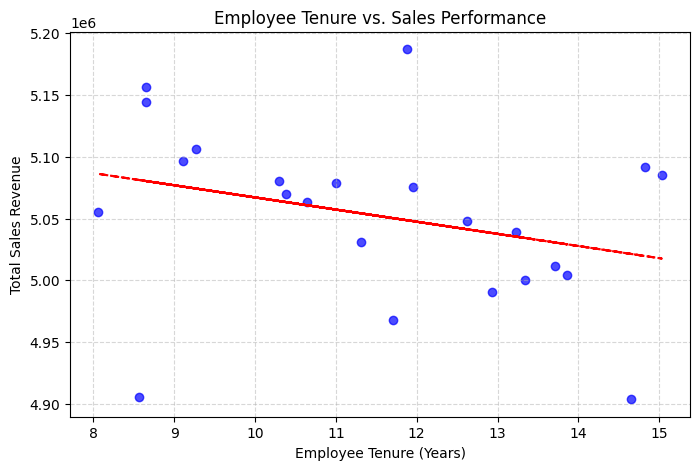

In [23]:
# Employee Analysis

# correlation between employees

sales_by_employee = merged_sales.groupby("SalesPersonID")["TotalPrice"].sum().reset_index()

# Merge sales data with employee details
sales_by_employee = sales_by_employee.merge(
    dataframes["employees"][["EmployeeID", "HireDate"]],
    left_on="SalesPersonID",
    right_on="EmployeeID",
    how="left"
)

# HireDate to datetime
sales_by_employee["HireDate"] = pd.to_datetime(sales_by_employee["HireDate"])

# tenure (years since hire date)
sales_by_employee["Tenure"] = (pd.to_datetime("today") - sales_by_employee["HireDate"]).dt.days / 365

# correlation between tenure and sales
correlation = sales_by_employee["Tenure"].corr(sales_by_employee["TotalPrice"])
print(f"Correlation between tenure and sales: {correlation:.2f}")

plt.figure(figsize=(8, 5))
plt.scatter(sales_by_employee["Tenure"], sales_by_employee["TotalPrice"], color="blue", alpha=0.7)
plt.xlabel("Employee Tenure (Years)")
plt.ylabel("Total Sales Revenue")
plt.title("Employee Tenure vs. Sales Performance")
plt.grid(True, linestyle="--", alpha=0.5)

# Best-fit trend line
m, b = np.polyfit(sales_by_employee["Tenure"], sales_by_employee["TotalPrice"], 1)
plt.plot(sales_by_employee["Tenure"], m*sales_by_employee["Tenure"] + b, color="red", linestyle="dashed")

plt.show()

